# Project name : Recognizing Traffic Signs

## Dataset Link :
### https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

## Deployed web-app : https://traffic-sign-recognition2701.herokuapp.com/

## Importing Necessary libraries

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import os
import warnings
import pickle
import matplotlib.image as mpimg

warnings.filterwarnings("ignore")

## Initiating useful and important variables and path

In [1]:
main_path = "./data/archive/"        
train_path = "./data/archive/Train/"
test_path = "./data/archive/Test/"
random_test_path = "../data/test_data/"

# Total Classes
total_classes = 43

# Making lists to store image data and labels
image_data = []
image_lables = []

# Image Height, width and no. of channels
height = 32
width = 32
channels = 3

## Loading & Preprocessing the images 

In [3]:
# Loading Images to one numpy array
def load_images():
    temp_image_data = []
    temp_image_lables = []
    for i in range(total_classes):
        path = train_path + str(i)
        imgs = os.listdir(path)
        for img in imgs:
            temp = cv2.imread(path + "/" + img)
            temp = Image.fromarray(temp, 'RGB')
            temp = temp.resize((height, width))
            temp_image_data.append(np.array(temp))
            temp_image_lables.append(i)

    # Converting lists into numpy arrays
    image_data = np.array(temp_image_data)
    image_lables = np.array(temp_image_lables)
    return image_data, image_lables

### Saving array of images into .npz file for future convenience

In [4]:
# Let's save entire image dataset numpy array to file so we can access it faster afterwords

# if os.path.exists('./data/data.npz') is False:
#     image_data, image_lables = load_images()
#     np.savez_compressed('./data/data.npz', image_data = image_data, image_lables = image_lables)
#     print("npz file created")
# else:
#     print("npz file already there")

### Opening .npz file and loading into array of image set and its label set

In [5]:
# loaded = np.load('./data/data.npz')
# image_data = loaded['image_data']
# image_lables = loaded['image_lables']

- <p style = "font-size : 18px "> Shape of input data and label data </p>

In [6]:
image_data, image_lables = load_images()
print(np.shape(image_data))
print(np.shape(image_lables))

(39209, 32, 32, 3)
(39209,)


### Normalizing image data on scale from 0 to 1

In [7]:
# Normalizing all images to scale from 0 to 1
image_data = image_data / 255

- <p style = "font-size : 18px "> Let's see our first input image before shuffling of dataset array </p>

Text(0.5, 1.0, 'First Image Before Shuffle')

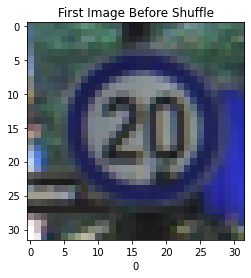

In [8]:
# Let's See first image before shuffle

plt.imshow(image_data[0])
plt.xlabel(image_lables[0])
plt.title("First Image Before Shuffle")

### Shuffling Data to random sequence

In [9]:
# Let's Shuffle our image data and labels together

s = np.arange(np.shape(image_data)[0])
np.random.shuffle(s)
image_data = image_data[s]
image_lables = image_lables[s]

- <p style = "font-size : 18px "> Now Let's see our first input image after shuffling of dataset array </p>

Text(0.5, 1.0, 'First Image After Shuffle')

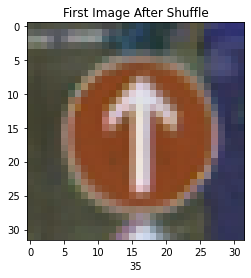

In [10]:
# Let's See first image after shuffle --> Changed right ??

plt.imshow(image_data[0])
plt.xlabel(image_lables[0])
plt.title("First Image After Shuffle")

## Splitting our dataset array into 2 parts 
<br>
<ul>
    <li style = "font-size : 18px ">
        Training dataset - 80 %
    </li>
    <br>
    <li style = "font-size : 18px ">
        Validation dataset - 20 %
    </li>
</ul>

In [11]:
# Splitting into train and validation set

X_train, X_valid, Y_train, Y_valid = train_test_split(image_data,
                                                      image_lables,
                                                      test_size=0.2,
                                                      shuffle=True)
# Dimensions
print("Training set size : " + str(X_train.shape))
print("Validation set size : " + str(X_valid.shape))
print("Training labels set size : " + str(Y_train.shape))
print("Validation labels set size : " + str(Y_valid.shape))

Training set size : (31367, 32, 32, 3)
Validation set size : (7842, 32, 32, 3)
Training labels set size : (31367,)
Validation labels set size : (7842,)


### Converting classes into categorical by one hot encodings
<br>

<a href = "https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/">
<p style = "color : blue; font-size : 16px">
    Click on this link for more information about One hot Encodings
</p>
</a>

In [12]:
# Converting the labels into one hot encoding
Y_train = tf.keras.utils.to_categorical(Y_train, total_classes)
Y_valid = tf.keras.utils.to_categorical(Y_valid, total_classes)

# The dimensions concur
print(Y_train.shape)
print(Y_valid.shape)

(31367, 43)
(7842, 43)


### Clearing previous session of keras model training if any

In [13]:
keras.backend.clear_session() # Clearing previous session if there was any
np.random.seed(2666)

<br>
<h3>
    Before creating model architecture let's get some details about CNN
</h3>
<h2>
    What is Convolutional neural networks? - ConvNet or CNN
</h2>
<p style = "font-size : 16px">
    - A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.
</p>
<p style = "font-size : 16px">
    - The architecture of a ConvNet is analogous to that of the connectivity pattern of Neurons in the Human Brain and was inspired by the organization of the Visual Cortex. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field. A collection of such fields overlap to cover the entire visual area.
</p>
<img src = "https://miro.medium.com/max/3288/1*uAeANQIOQPqWZnnuH-VEyw.jpeg" alt = "CNN">

## Creating Model Architecture of Convolutional Neural Networks


In [14]:
def my_model():
    input_ = tf.keras.layers.Input((height, width, channels))
    net = tf.keras.layers.Conv2D(filters=18, kernel_size=(5,5), strides=1, activation="relu")(input_)
    net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    
    net = tf.keras.layers.Conv2D(filters=36, kernel_size=(5,5), strides=1, activation="relu",
                                 kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01))(net)
    net = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(net)
    
    net = tf.keras.layers.Conv2D(filters=36, kernel_size=(5,5), activation="relu")(net)
    net = tf.keras.layers.MaxPooling2D(pool_size=(1, 1))(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    
    net = tf.keras.layers.Flatten()(net)
    net = tf.keras.layers.Dense(72, activation= 'relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.01), bias_regularizer=tf.keras.regularizers.l2(0.01))(net)
    out = tf.keras.layers.Dense(total_classes, activation='softmax')(net)
    
    model = tf.keras.Model(inputs=[input_], outputs=[out])

    model.compile(loss=tf.keras.losses.categorical_crossentropy, 
                  optimizer=tf.keras.optimizers.Adam(lr=0.005), 
                  metrics=['accuracy'])
    model.summary()
    tf.keras.utils.plot_model(model, to_file='./model.png', show_shapes=True)
    return model

In [15]:
model = my_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 18)        1368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 18)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 18)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 36)        16236     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 36)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 36)          32436 

### Compiling model and tuning some hyperparameters

In [16]:
# Compilation of our model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

### You will wondering why we need this loss and optimizer while compiling the model
<br>
  <li style = "font-size : 18px"> 
       Basically this is very large topic and it is difficult to explain here so i am providing you some reference links so you can refer to it.
   </li>
   <br>
<a href = "https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/" style = "font-size : 15px">Why need loss function and Optimizers in neural networks?</a>
   

### Defining Callbacks
<br>
<h3>
    First let's understand what is callbacks?
</h3>
<br>
<li style = "font-size : 18px"> 
        A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.
</li>
<br>
<a href = "https://towardsdatascience.com/callbacks-in-neural-networks-b0b006df7626" style = "font-size : 15px">What is callbacks?</a>
<br>
<a href = "https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/" style = "font-size : 15px">Why and How to use callbacks in neural networks?</a>

In [17]:
# Defining Callbacks

# Callback 01 --> When validation accuracy reached at satisfied level, it will automatically stops training
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98 and logs.get('accuracy')>0.9750):
            print("\nSatisfied Critarea so cancelling training!")
            self.model.save("./model_best.h5")
            self.model.stop_training = True

# Callback 02 --> When validation loss is not decreasing consecutively 2 times 
# it will decrease Learning Rate by 0.95 factor
reduceLROnPlat = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.95,
        patience=2,
        verbose=1,
        mode='min',
        min_delta=0.0001,
        cooldown=2,
        min_lr=1e-5
)

# Callback 03 --> Whenever validation loss is less than previous one it will save model named model_best_2.h5
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./model_best_3.h5", monitor='val_loss', verbose=1, save_best_only=False,
    save_weights_only=False, mode='min', save_freq='epoch'
)

my_callback = myCallback()

## Now let's train our model

In [18]:
start = time.time()
history = model.fit(X_train, Y_train, batch_size=32,
                    validation_data=(X_valid, Y_valid),
                    epochs = 50, # You can also train more epochs and get much better model
                    callbacks=[my_callback, reduceLROnPlat, checkpoint])
end = time.time()
print(f"Total training time taken : {round(end - start, 5)}")

Epoch 1/50
981/981 [==============================] - 33s 28ms/step - loss: 2.2016 - accuracy: 0.4250 - val_loss: 1.0666 - val_accuracy: 0.7540

Epoch 00001: saving model to ./model_best_3.h5
Epoch 2/50
981/981 [==============================] - 24s 25ms/step - loss: 1.1166 - accuracy: 0.7187 - val_loss: 0.6673 - val_accuracy: 0.8959

Epoch 00002: saving model to ./model_best_3.h5
Epoch 3/50
981/981 [==============================] - 23s 23ms/step - loss: 0.8789 - accuracy: 0.7912 - val_loss: 0.5310 - val_accuracy: 0.9292

Epoch 00003: saving model to ./model_best_3.h5
Epoch 4/50
981/981 [==============================] - 37s 38ms/step - loss: 0.7587 - accuracy: 0.8233 - val_loss: 0.4480 - val_accuracy: 0.9390

Epoch 00004: saving model to ./model_best_3.h5
Epoch 5/50
981/981 [==============================] - 33s 34ms/step - loss: 0.6859 - accuracy: 0.8468 - val_loss: 0.3940 - val_accuracy: 0.9490

Epoch 00005: saving model to ./model_best_3.h5
Epoch 6/50
981/981 [====================

981/981 [==============================] - 33s 34ms/step - loss: 0.2960 - accuracy: 0.9478 - val_loss: 0.1794 - val_accuracy: 0.9871

Epoch 00042: saving model to ./model_best_3.h5
Epoch 43/50
981/981 [==============================] - 25s 25ms/step - loss: 0.2838 - accuracy: 0.9500 - val_loss: 0.1749 - val_accuracy: 0.9879

Epoch 00043: saving model to ./model_best_3.h5
Epoch 44/50
981/981 [==============================] - 23s 23ms/step - loss: 0.2886 - accuracy: 0.9483 - val_loss: 0.1728 - val_accuracy: 0.9883

Epoch 00044: saving model to ./model_best_3.h5
Epoch 45/50
981/981 [==============================] - 23s 23ms/step - loss: 0.2894 - accuracy: 0.9486 - val_loss: 0.1735 - val_accuracy: 0.9869

Epoch 00045: saving model to ./model_best_3.h5
Epoch 46/50
981/981 [==============================] - 27s 28ms/step - loss: 0.2873 - accuracy: 0.9497 - val_loss: 0.1961 - val_accuracy: 0.9804

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.000735091819660738.

Epoch 00046: s

### Of course, It will take upto an hour to train model but training time depends on your hardware configuration you can use google colab if you don't have any GPUs or powerful CPUs.

### Let's take a look on logs of training

In [19]:
with open('./trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [27]:
history = pickle.load(open('./trainHistoryDict', 'rb'))

df2 = pd.DataFrame(history)
df2

,loss,accuracy,val_loss,val_accuracy,lr
0,2.201615,0.424969,1.066645,0.754017,0.001000
1,1.116557,0.718749,0.667306,0.895945,0.001000
2,0.878933,0.791214,0.531017,0.929227,0.001000
3,0.758703,0.823318,0.448026,0.939046,0.001000
4,0.685874,0.846814,0.393959,0.948993,0.001000
5,0.631153,0.862084,0.380513,0.956389,0.001000
6,0.577914,0.879109,0.348462,0.957281,0.001000
7,0.546622,0.887270,0.319451,0.965187,0.001000
8,0.514731,0.895782,0.303810,0.966590,0.001000
9,0.496113,0.898715,0.286654,0.971308,0.001000


### Boring and confused right???
<img src = "https://media.giphy.com/media/ji6zzUZwNIuLS/giphy.gif" alt = "Bored">


### Let's Visualize it and get some insights

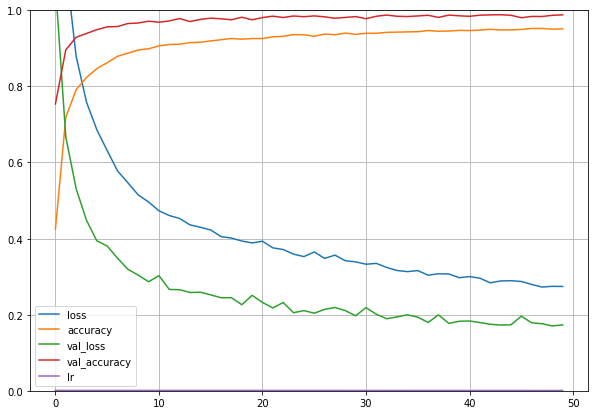

In [37]:
pd.DataFrame(history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Observations 

<p style = "font-size : 18px">
    - As you can see in graph, loss and validation loss are decreasing rapidly in first 10 - 15 iterations but after  that it starts to diverge so learning rate is decreased by model to converge into right direction.
    <br>
    - Same as loss and validation loss, accuracy and validation accuray are increasing rapidly in first 5 - 10 iterations then starts to slow down. 
    <br>
    - But at the end of training, we got <b> 95.12 %  Training accuracy </b> and <b> 98.80 %  Validation accuracy </b> so it is clear that our model is "just right" means not overfitting and not underfitting to data so we are going ahead now.
</p>

### I trained 3 different models using 3 different hyperparameter tuning and methods but as far this is best model which has accuracy around 95% on unseen test dataset so let's see it from here.

<img src = "../model_comparison.png" alt = "Comparision">

## Let's Validate our model on unseen Test dataset 

<p style = "font-size : 17px">
    Test data is stored in Test directory but its information like class_id etc is stored in Test.csv so let's see that first and then go ahead.
</p>

In [38]:
df = pd.read_csv("./data/archive/Test.csv")
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [4]:
model_best = tf.keras.models.load_model("../models/model_best.h5")

In [42]:
def checking_performance(df, model, input_path):
    labels = df['ClassId'].values
    path = df['Path'].values
    final_res = []
    count = 0
    correct = 0
    for img in input_path + path:
#         if count == 1000:
#             break
    #     img1 = tf.keras.preprocessing.image.load_img(img, target_size=(32, 32))
    #     test_img = tf.keras.preprocessing.image.img_to_array(img1, data_format="channels_last")/255
    #     test_img = np.expand_dims(test_img, axis=0)
        img1 = cv2.imread(img)
        temp = Image.fromarray(img1, 'RGB')
        temp = temp.resize((32, 32))
        test_img = np.array(temp) / 255
        test_img = np.expand_dims(test_img, axis=0)
        scores = model.predict(test_img)
        preds = np.argmax(scores, axis = 1)
        final_res.append(preds)
        if preds == labels[count]:
            correct += 1
        count += 1

    print(f"Total Count : {count}\tTotal correct : {correct}", end="\t")
    print(round(accuracy_score(labels[:count], final_res, normalize = True), 5) * 100, end="\n")

In [43]:
checking_performance(df, model_best, main_path)

Total Count : 12630	Total correct : 11933	94.48100000000001


In [44]:
from keras import backend as K
K.clear_session()

## Visualization of images and classes predicted by model

In [7]:
# Dictionary to map classes.
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
          }

In [16]:
def get_output(img):
#     img1 = tf.keras.preprocessing.image.load_img(img, target_size=(224, 224), interpolation='nearest')
#     test_img = tf.keras.preprocessing.image.img_to_array(img1, data_format="channels_last")/255
#     test_img = np.expand_dims(test_img, axis=0)
    img1 = cv2.imread(img)
    temp = Image.fromarray(img1, 'RGB')
    temp = temp.resize((32, 32))
    test_img = np.array(temp) / 255
    test_img = np.expand_dims(test_img, axis=0)
    scores = model_best.predict(test_img)
    prob = np.max(scores, axis = 1)
    preds = np.argmax(scores, axis = 1)
#     print(f"{prob[0] * 100}% probability of {classes[preds[0]]}")
    return f"{classes[preds[0]]} -- {round(prob[0] * 100, 2)} %"

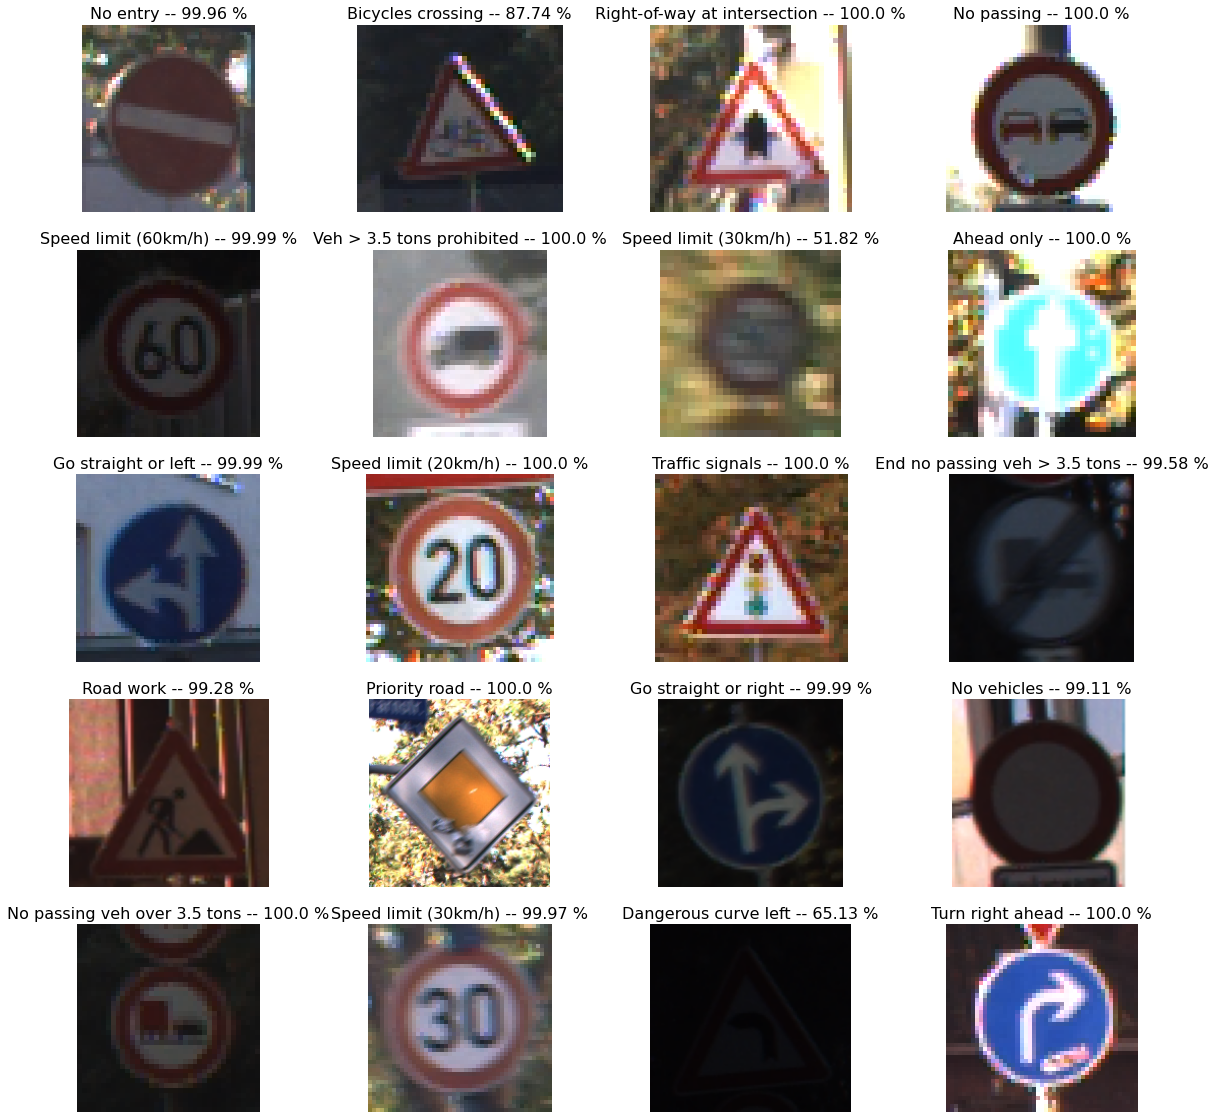

In [23]:
images = [file for file in os.listdir(random_test_path)]
ind = 0
plt.figure(figsize=(20, 20))
for i in range(1, 21):
    plt.subplot(5, 4, i)
    plt.axis("off")
    if ind > len(images):
        break
    img = mpimg.imread(random_test_path + images[ind])
    plt.imshow(img)
    plt.title(get_output(random_test_path + images[ind]), fontsize = 16)
    ind += 1